In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import joblib
import ta

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Data Gathering 


In [132]:
STOCK_SYMBOLS = [
	"AAPL",
	"GOOGL",
	"MSFT",
	"AMZN",
	"TSLA",
	"NFLX",
	"NVDA",
	"INTC",
	"CSCO",
	"ADBE",
	"ORCL",
	"IBM",
	"CRM",
	"QCOM",
	"AVGO",
	"TXN",
	"AMD",
	"MU",
	"HPQ",
	"DELL",
	"SAP",
	"UBER",
]

In [133]:
#Download Data
start_date = "2015-01-01"
end_date = str(datetime.now().date())

dfs = {}
for ticker in STOCK_SYMBOLS:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    dfs[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [134]:
dfs["AAPL"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        2544 non-null   datetime64[ns]
 1   (Close, AAPL)   2544 non-null   float64       
 2   (High, AAPL)    2544 non-null   float64       
 3   (Low, AAPL)     2544 non-null   float64       
 4   (Open, AAPL)    2544 non-null   float64       
 5   (Volume, AAPL)  2544 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 119.4 KB


In [135]:
#Saving Training Dates
train_dates = {}

for ticker in STOCK_SYMBOLS:
    train_dates[ticker] = pd.to_datetime(dfs[ticker]["Date"])

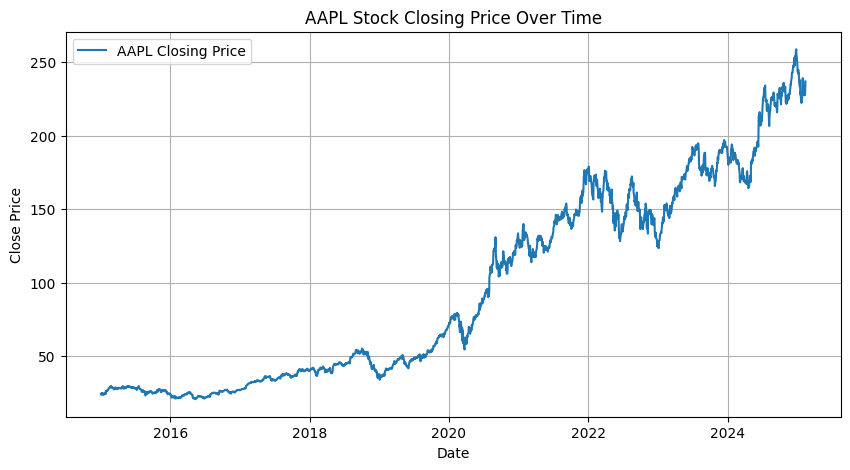

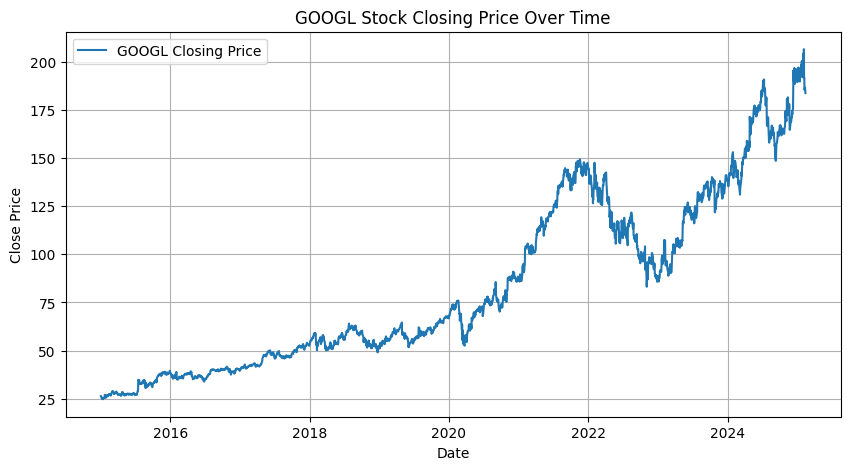

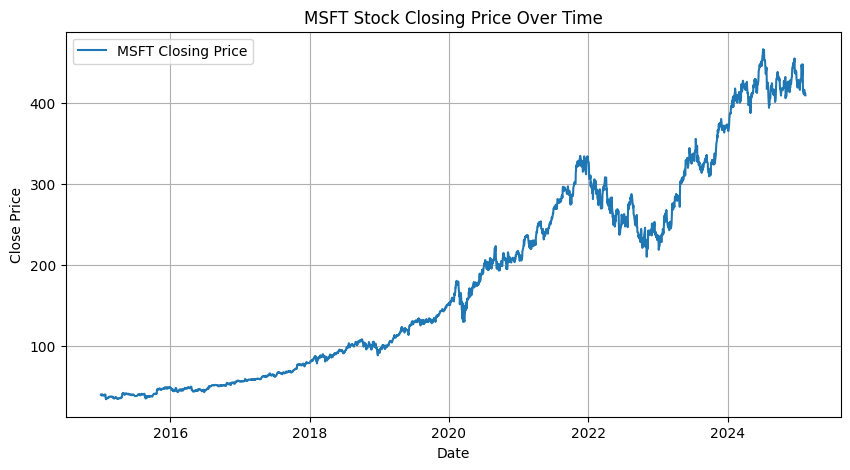

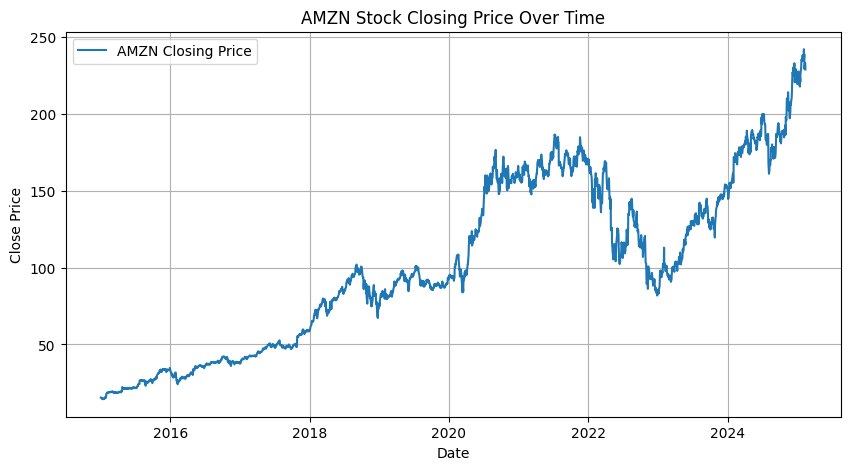

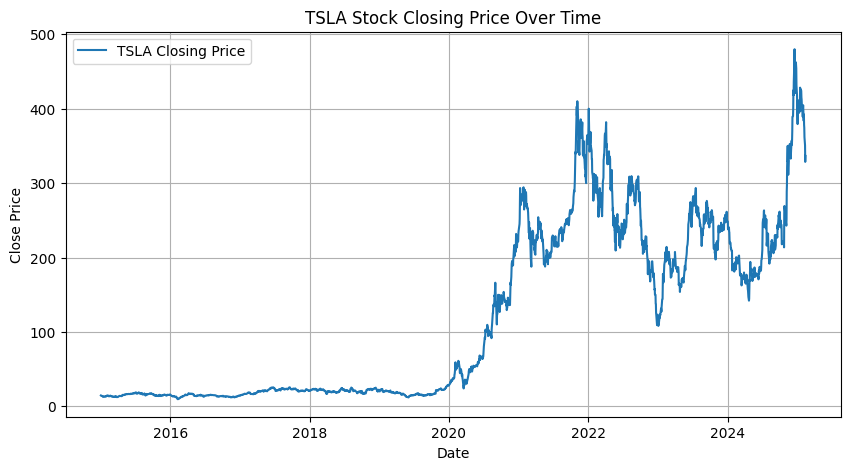

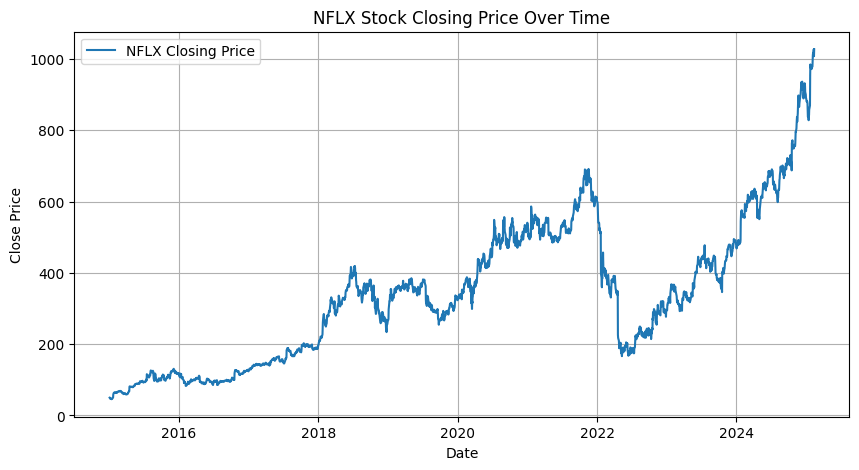

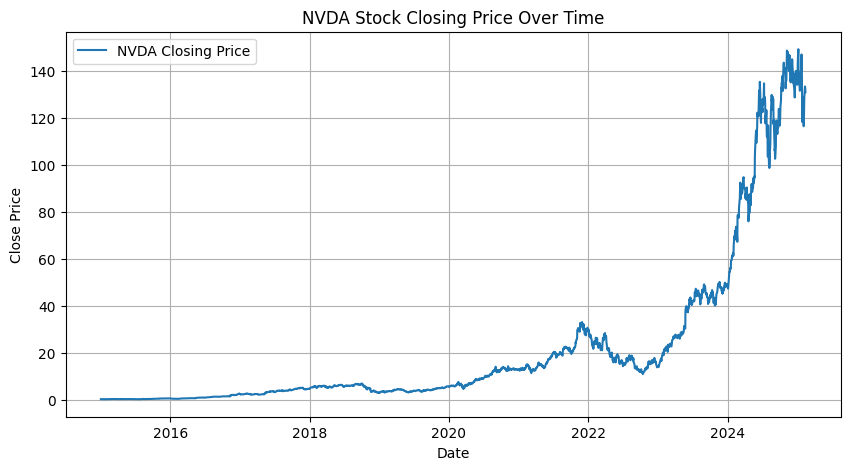

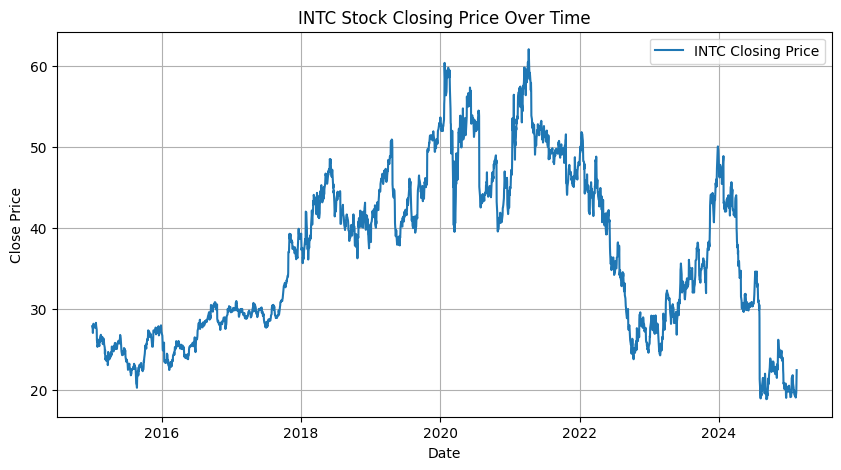

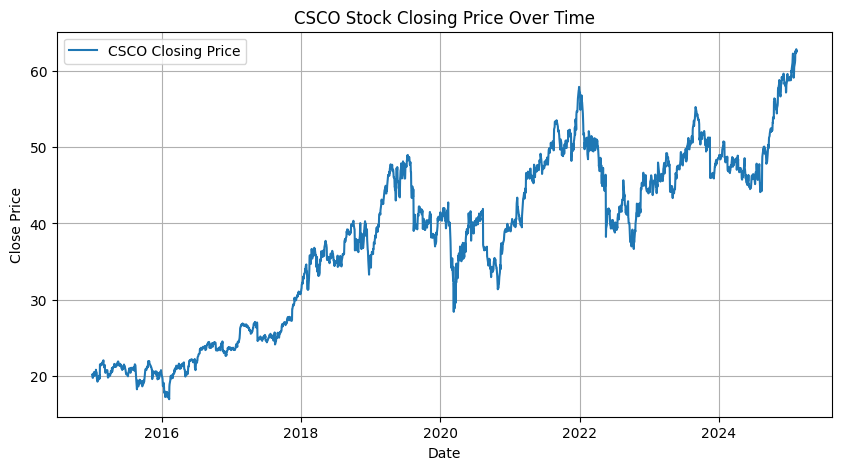

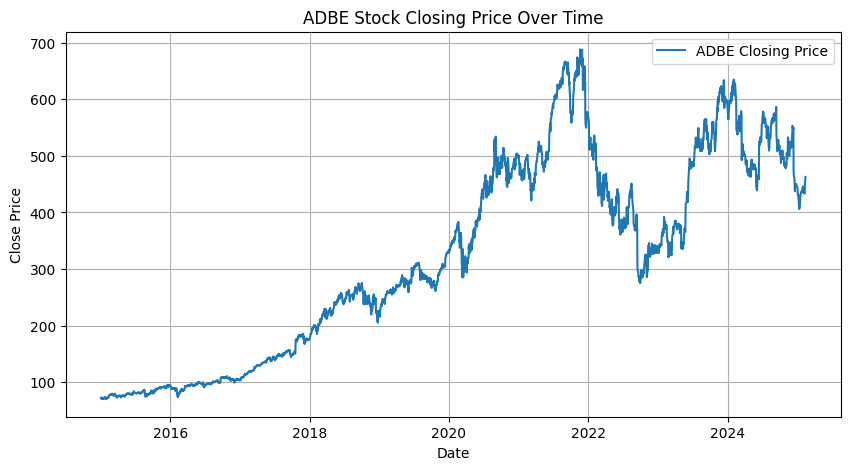

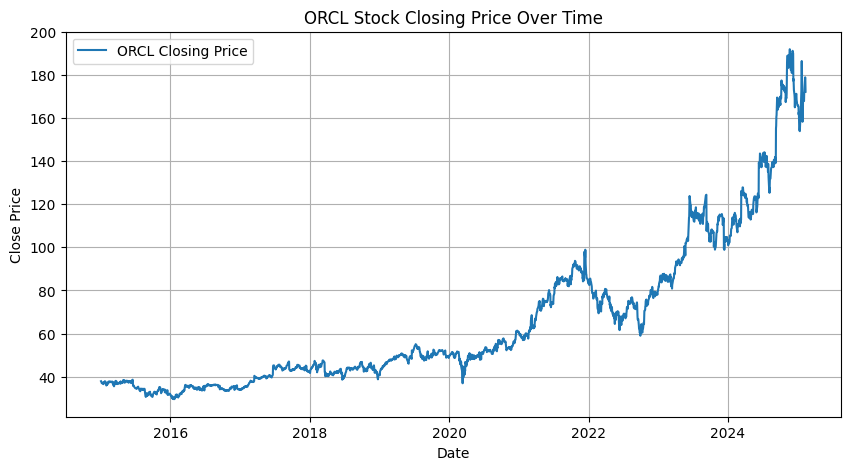

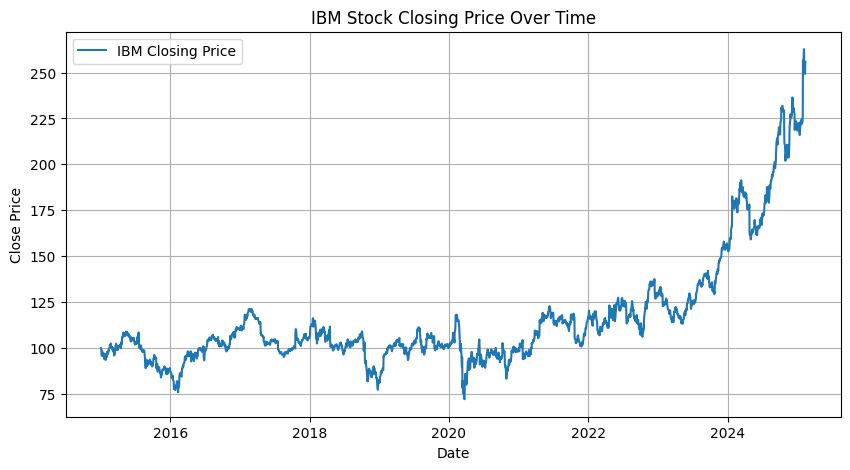

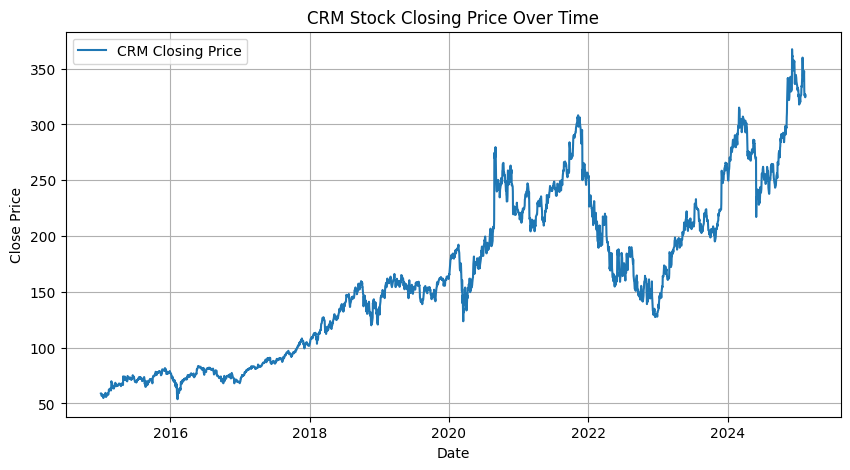

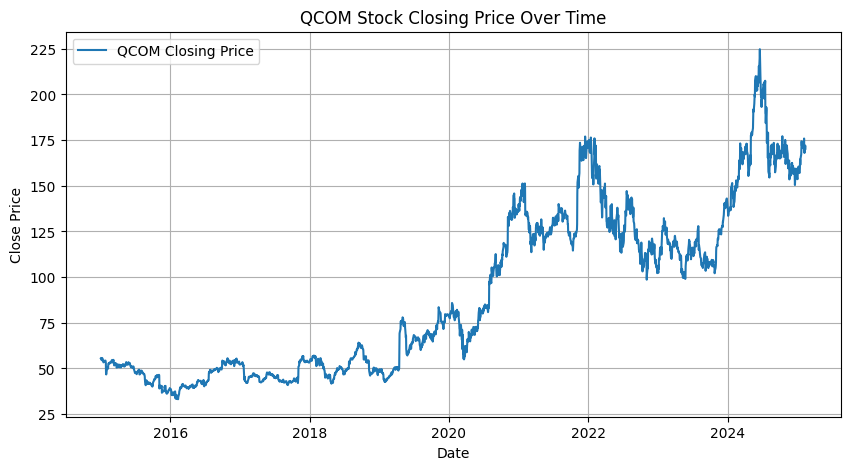

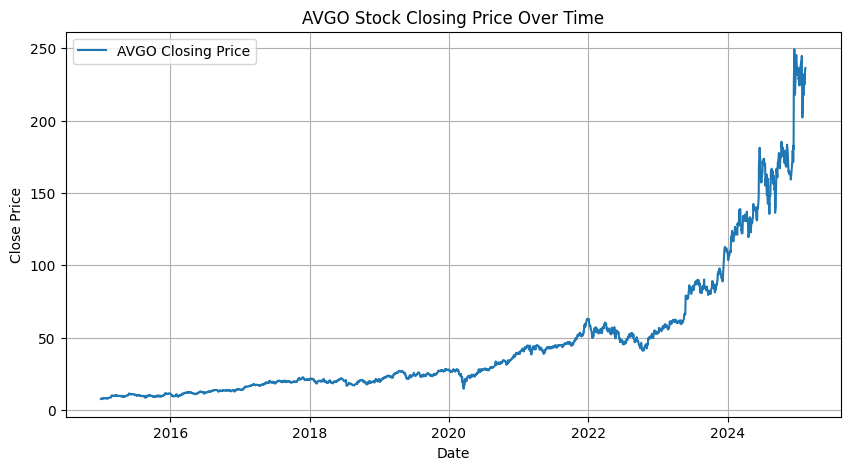

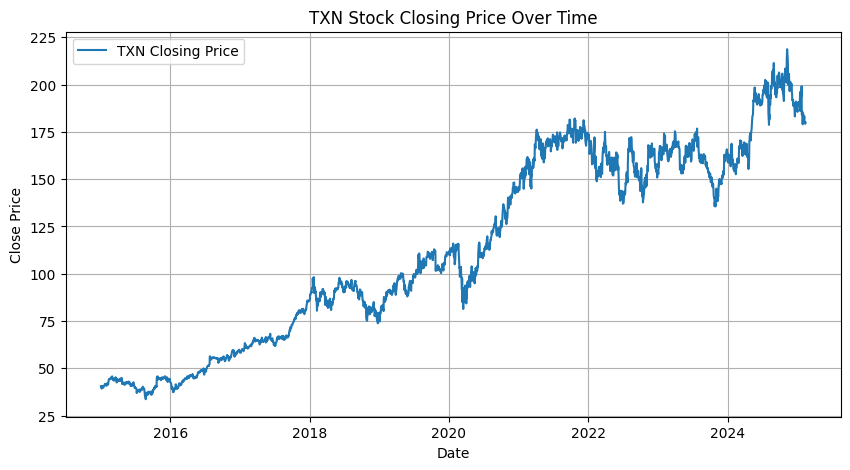

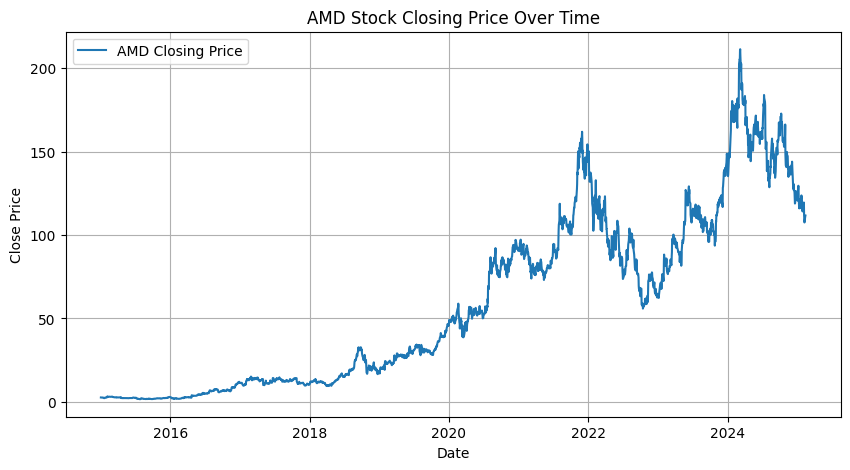

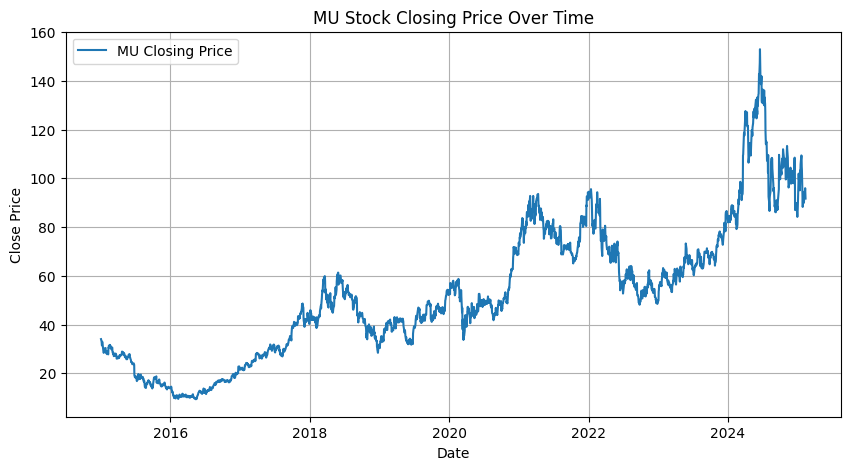

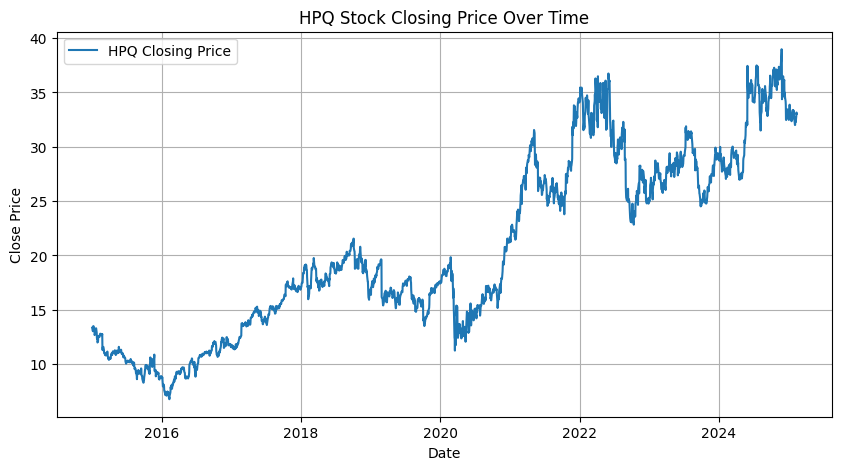

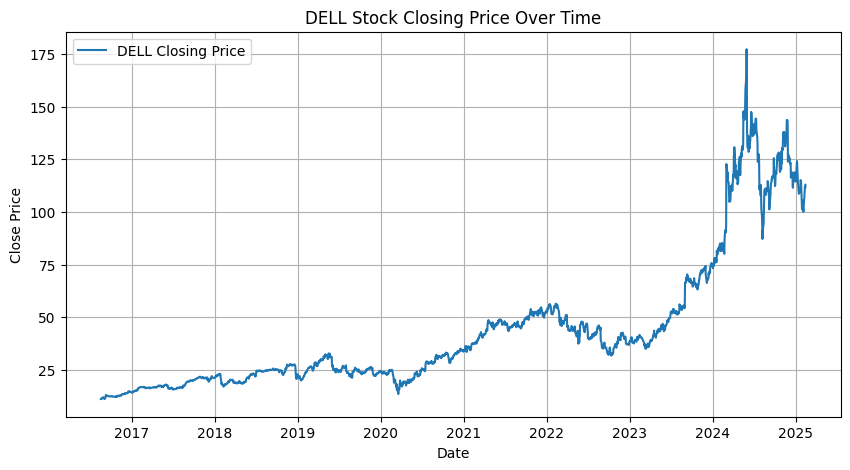

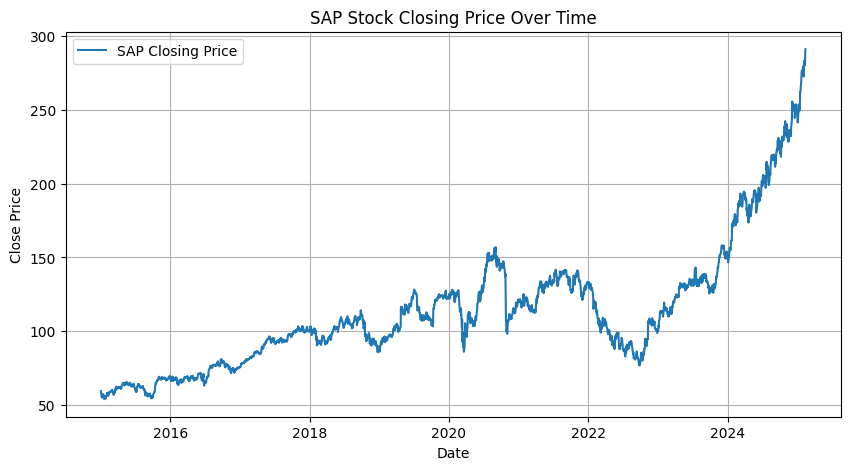

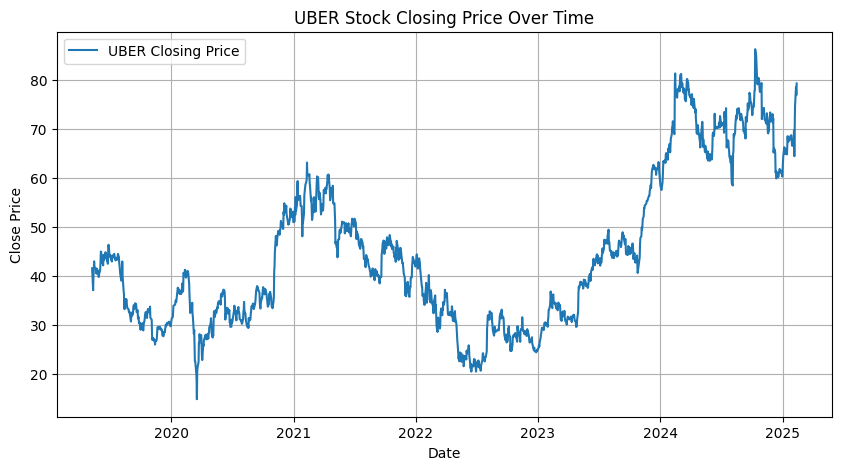

In [136]:
#plotting data
for ticker in STOCK_SYMBOLS:
    plt.figure(figsize=(10,5))
    plt.plot(dfs[ticker]['Date'], dfs[ticker]['Close'], label=f"{ticker} Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"{ticker} Stock Closing Price Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# Preprocessing

In [137]:
#SMA: Simple Moving Average, which is a technical indicator that calculates the average price of a stock over a given period of time.

SMA_WINDOW = 10
for ticker in STOCK_SYMBOLS:
    dfs[ticker]['SMA'] = dfs[ticker]['Close'].rolling(window=SMA_WINDOW).mean()

In [138]:
#RSI: Relative Strength Index, a technical indicator used to assess the strength of a stock or other financial instrument.

RSI_WINDOW = 14
for ticker in STOCK_SYMBOLS:
    dfs[ticker]['RSI'] = ta.momentum.rsi(dfs[ticker]['Close'].squeeze(), window=RSI_WINDOW)

In [139]:
#removing the Date and Volume Column
for ticker in STOCK_SYMBOLS:
    dfs[ticker] = dfs[ticker][['Close', 'SMA', 'RSI']]

In [140]:
#removing last 14 days as RSI and SMA are NaN
for ticker in STOCK_SYMBOLS:
    dfs[ticker] = dfs[ticker].iloc[14:]
    dfs[ticker].reset_index(drop=True, inplace=True)

In [142]:
dfs["AAPL"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, AAPL)  2530 non-null   float64
 1   (SMA, )        2530 non-null   float64
 2   (RSI, )        2530 non-null   float64
dtypes: float64(3)
memory usage: 59.4 KB


In [143]:
dfs["AAPL"].head()

Price,Close,SMA,RSI
Ticker,AAPL,,
0,25.132378,24.419201,62.490225
1,25.159071,24.443448,62.809603
2,24.278162,24.441001,48.218514
3,25.650682,24.554227,62.741586
4,26.449278,24.756657,68.310735


In [ ]:
# creating scaler and scaled data dict
scaler = {}
dfs_training = {}

for ticker in STOCK_SYMBOLS:
    scaler[ticker] = StandardScaler()
    dfs_training[ticker] = scaler[ticker].fit_transform(dfs[ticker])

In [145]:
#Defining train and test dicts
X = {ticker: [] for ticker in STOCK_SYMBOLS}
y = {ticker: [] for ticker in STOCK_SYMBOLS}

In [ ]:
#Defining past and future days
d_future = 1
d_past = 21

In [ ]:
#Updating X and y
for ticker in STOCK_SYMBOLS:
    data = dfs_training[ticker]
    for i in range(d_past, len(data) - d_future + 1):
        X[ticker].append(data[i - d_past:i, :])
        y[ticker].append(data[i + d_future - 1, 0])

In [ ]:
#converting X and y to numpy arrays
for ticker in STOCK_SYMBOLS:
    X[ticker] = np.array(X[ticker])
    y[ticker] = np.array(y[ticker])

In [151]:
#Checking the shape of X and y
print("Shape of X:")
for ticker in STOCK_SYMBOLS:
    print(f"For [{ticker}]: {X[ticker].shape}")
print("Shape of y:")
for ticker in STOCK_SYMBOLS:
    print(f"For [{ticker}]: {y[ticker].shape}")

Shape of X:
For [AAPL]: (2509, 21, 3)
For [GOOGL]: (2509, 21, 3)
For [MSFT]: (2509, 21, 3)
For [AMZN]: (2509, 21, 3)
For [TSLA]: (2509, 21, 3)
For [NFLX]: (2509, 21, 3)
For [NVDA]: (2509, 21, 3)
For [INTC]: (2509, 21, 3)
For [CSCO]: (2509, 21, 3)
For [ADBE]: (2509, 21, 3)
For [ORCL]: (2509, 21, 3)
For [IBM]: (2509, 21, 3)
For [CRM]: (2509, 21, 3)
For [QCOM]: (2509, 21, 3)
For [AVGO]: (2509, 21, 3)
For [TXN]: (2509, 21, 3)
For [AMD]: (2509, 21, 3)
For [MU]: (2509, 21, 3)
For [HPQ]: (2509, 21, 3)
For [DELL]: (2100, 21, 3)
For [SAP]: (2509, 21, 3)
For [UBER]: (1414, 21, 3)
Shape of y:
For [AAPL]: (2509,)
For [GOOGL]: (2509,)
For [MSFT]: (2509,)
For [AMZN]: (2509,)
For [TSLA]: (2509,)
For [NFLX]: (2509,)
For [NVDA]: (2509,)
For [INTC]: (2509,)
For [CSCO]: (2509,)
For [ADBE]: (2509,)
For [ORCL]: (2509,)
For [IBM]: (2509,)
For [CRM]: (2509,)
For [QCOM]: (2509,)
For [AVGO]: (2509,)
For [TXN]: (2509,)
For [AMD]: (2509,)
For [MU]: (2509,)
For [HPQ]: (2509,)
For [DELL]: (2100,)
For [SAP]: (2509,

# Model Creation

In [221]:
#defining model
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', return_sequences=True, input_shape=(X["AAPL"].shape[1], X["AAPL"].shape[2])))
    model.add(LSTM(units=units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [209]:
create_lstm_model(units=50, dropout_rate=0.2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 21, 50)            10800     
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_28 (Dropout)        (None, 50)                0         
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 31051 (121.29 KB)
Trainable params: 31051 (121.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
#tuning hyperparameter
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2],
    'epochs': [10, 20],
    'batch_size': [16, 32]
}

In [213]:
#early stopping
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
best_models = {}

In [220]:
# Training the model for each stock:
for ticker in STOCK_SYMBOLS:
    print(f"\n\nTuning model for {ticker} ...")
    
    X_stock = X[ticker]
    y_stock = y[ticker]
    
    regressor = KerasRegressor(build_fn=create_lstm_model, verbose=1)
    
    halving_search = HalvingGridSearchCV(
        estimator=regressor,
        param_grid=param_grid,
        factor=2,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1,
    )
    
    halving_search.fit(X_stock, y_stock, callbacks=[early_stopping])
    
    print(f"Best parameters for {ticker}: {halving_search.best_params_}")
    print(f"Best score (neg MSE) for {ticker}: {halving_search.best_score_}")
    
    # Store the best estimator in the dictionary.
    best_models[ticker] = halving_search.best_estimator_

print("\nAll best models saved.")



Tuning model for AAPL ...
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 313
max_resources_: 2509
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 313
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 626
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 1252
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 2504
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 21, 100)           41600     
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                        

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 4s 14ms/step - loss: 0.0807
Epoch 2/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0245
Epoch 3/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0243
Epoch 4/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0210
Epoch 5/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0221
Epoch 6/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0204
Epoch 7/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0211
Epoch 8/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0189
Epoch 9/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0203
Epoch 10/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0180
Epoch 11/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0202
Epoch 12/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0196
Epoch 13/20
157/157 [===

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 4s 12ms/step - loss: 0.0866
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0278
Epoch 3/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0274
Epoch 4/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0288
Epoch 5/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0242
Epoch 6/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0265
Epoch 7/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0238
Epoch 8/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0217
Epoch 9/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0224
Epoch 10/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0219
Epoch 11/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0222
Epoch 12/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0208
Epoch 13/20
157/157 [===

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 4s 12ms/step - loss: 0.0752
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0240
Epoch 3/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0211
Epoch 4/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0221
Epoch 5/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0216
Epoch 6/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0207
Epoch 7/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0204
Epoch 8/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0210
Epoch 9/20
157/157 [==============================] - 2s 13ms/step - loss: 0.0193
Epoch 10/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0180
Epoch 11/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0183
Epoch 12/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0188
Epoch 13/20
157/157 [===

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


79/79 [==============================] - 3s 15ms/step - loss: 0.1177
Epoch 2/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0339
Epoch 3/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0293
Epoch 4/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0281
Epoch 5/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0291
Epoch 6/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0267
Epoch 7/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0249
Epoch 8/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0235
Epoch 9/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0230
Epoch 10/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0236
Epoch 11/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0218
Epoch 12/20
79/79 [==============================] - 1s 15ms/step - loss: 0.0214
Epoch 13/20
79/79 [=============================

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 21, 100)           41600     
                                                                 
 lstm_39 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_38 (Dropout)        (None, 100)               0         
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122101 (476.96 KB)
Trainable params: 122101 (476.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
79/79 [=============

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 21, 100)           41600     
                                                                 
 lstm_41 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_40 (Dropout)        (None, 100)               0         
                                                                 
 dropout_41 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122101 (476.96 KB)
Trainable params: 122101 (476.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 dropout_43 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122101 (476.96 KB)
Trainable params: 122101 (476.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
79/79 [==============================] - 5s 28ms/step - loss: 0.2058
Epoch 2/10
79/79 [==============================] - 2s 27ms/step - loss: 0.0412
Epoch 3/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0348
Epoch 4/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0363
Epoch 5/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0289
Epoch 6/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0296
Epoch 7/10
79/79 [==============================] - 2s 28ms/step - loss: 0.0267

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 21, 100)           41600     
                                                                 
 lstm_45 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_44 (Dropout)        (None, 100)               0         
                                                                 
 dropout_45 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122101 (476.96 KB)
Trainable params: 122101 (476.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
157/157 [===========

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 2s 7ms/step - loss: 0.1221
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.0530
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.0453
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0434
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0405
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0402
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0383
Epoch 8/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0399
Epoch 9/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0389
Epoch 10/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0388
Best parameters for CSCO: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 50}
Best score (neg MSE) for CSCO: -0.024608897435398555


Tuning model for ADBE ...
n_iterations

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


79/79 [==============================] - 3s 15ms/step - loss: 0.1211
Epoch 2/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0277
Epoch 3/10
79/79 [==============================] - 2s 24ms/step - loss: 0.0271
Epoch 4/10
79/79 [==============================] - 3s 35ms/step - loss: 0.0254
Epoch 5/10
79/79 [==============================] - 2s 31ms/step - loss: 0.0247
Epoch 6/10
79/79 [==============================] - 1s 18ms/step - loss: 0.0246
Epoch 7/10
79/79 [==============================] - 1s 18ms/step - loss: 0.0256
Epoch 8/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0222
Epoch 9/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0212
Epoch 10/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0222
Best parameters for ADBE: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 100}
Best score (neg MSE) for ADBE: -0.007280204673255353


Tuning model for ORCL ...
n_iterations: 4
n_req

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 3s 10ms/step - loss: 0.2996
Epoch 2/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0458
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0320
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0284
Epoch 5/10
157/157 [==============================] - 1s 10ms/step - loss: 0.0278
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0279
Epoch 7/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0259
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0226
Epoch 9/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0231
Epoch 10/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0246
Best parameters for ORCL: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 100}
Best score (neg MSE) for ORCL: -0.02873098051121006


Tuning model for IBM ...
n_i

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


79/79 [==============================] - 2s 7ms/step - loss: 0.2518
Epoch 2/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0790
Epoch 3/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0532
Epoch 4/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0609
Epoch 5/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0549
Epoch 6/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0503
Epoch 7/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0479
Epoch 8/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0439
Epoch 9/20
79/79 [==============================] - 1s 8ms/step - loss: 0.0497
Epoch 10/20
79/79 [==============================] - 1s 9ms/step - loss: 0.0533
Epoch 11/20
79/79 [==============================] - 1s 7ms/step - loss: 0.0472
Epoch 12/20
79/79 [==============================] - 1s 9ms/step - loss: 0.0489
Epoch 13/20
79/79 [==============================] - 1s 8ms/

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 5s 12ms/step - loss: 0.0957
Epoch 2/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0343
Epoch 3/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0294
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0273
Epoch 5/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0301
Epoch 6/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0242
Epoch 7/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0233
Epoch 8/10
157/157 [==============================] - 2s 11ms/step - loss: 0.0238
Epoch 9/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0255
Epoch 10/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0263
Best parameters for CRM: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 100}
Best score (neg MSE) for CRM: -0.035936524803487864


Tuning model for QCOM ...
n_i

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 21, 100)           41600     
                                                                 
 lstm_57 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_56 (Dropout)        (None, 100)               0         
                                                                 
 dropout_57 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122101 (476.96 KB)
Trainable params: 122101 (476.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
79/79 [=============

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


79/79 [==============================] - 3s 23ms/step - loss: 0.1745
Epoch 2/20
79/79 [==============================] - 2s 22ms/step - loss: 0.0450
Epoch 3/20
79/79 [==============================] - 2s 21ms/step - loss: 0.0363
Epoch 4/20
79/79 [==============================] - 1s 17ms/step - loss: 0.0301
Epoch 5/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0287
Epoch 6/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0238
Epoch 7/20
79/79 [==============================] - 1s 17ms/step - loss: 0.0342
Epoch 8/20
79/79 [==============================] - 1s 14ms/step - loss: 0.0313
Epoch 9/20
79/79 [==============================] - 1s 14ms/step - loss: 0.0313
Epoch 10/20
79/79 [==============================] - 1s 13ms/step - loss: 0.0295
Epoch 11/20
79/79 [==============================] - 1s 14ms/step - loss: 0.0249
Epoch 12/20
79/79 [==============================] - 1s 14ms/step - loss: 0.0300
Epoch 13/20
79/79 [=============================

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


None
Epoch 1/20
79/79 [==============================] - 4s 24ms/step - loss: 0.0996
Epoch 2/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0302
Epoch 3/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0279
Epoch 4/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0236
Epoch 5/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0244
Epoch 6/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0224
Epoch 7/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0221
Epoch 8/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0231
Epoch 9/20
79/79 [==============================] - 2s 24ms/step - loss: 0.0220
Epoch 10/20
79/79 [==============================] - 2s 23ms/step - loss: 0.0241
Epoch 11/20
79/79 [==============================] - 2s 23ms/step - loss: 0.0198
Epoch 12/20
79/79 [==============================] - 2s 23ms/step - loss: 0.0192
Epoch 13/20
79/79 [=============

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 3s 10ms/step - loss: 0.1009
Epoch 2/10
157/157 [==============================] - 1s 10ms/step - loss: 0.0332
Epoch 3/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0287
Epoch 4/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0328
Epoch 5/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0284
Epoch 6/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0252
Epoch 7/10
157/157 [==============================] - 1s 9ms/step - loss: 0.0246
Epoch 8/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0252
Epoch 9/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0216
Epoch 10/10
157/157 [==============================] - 2s 10ms/step - loss: 0.0247
Best parameters for AMD: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 100}
Best score (neg MSE) for AMD: -0.013083529875556036


Tuning model for MU ...
n_iter

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 3s 10ms/step - loss: 0.1052
Epoch 2/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0358
Epoch 3/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0339
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0312
Epoch 5/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0289
Epoch 6/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0294
Epoch 7/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0274
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0257
Epoch 9/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0271
Epoch 10/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0215
Epoch 11/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0278
Epoch 12/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0253
Epoch 13/20
157/157 [======

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 3s 10ms/step - loss: 0.0766
Epoch 2/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0320
Epoch 3/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0285
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0261
Epoch 5/20
157/157 [==============================] - 1s 10ms/step - loss: 0.0264
Epoch 6/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0274
Epoch 7/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0241
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0246
Epoch 9/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0251
Epoch 10/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0230
Epoch 11/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0235
Epoch 12/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0216
Epoch 13/20
157/157 [===

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


132/132 [==============================] - 3s 10ms/step - loss: 0.0996
Epoch 2/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0370
Epoch 3/10
132/132 [==============================] - 1s 11ms/step - loss: 0.0308
Epoch 4/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0382
Epoch 5/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0322
Epoch 6/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0298
Epoch 7/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0247
Epoch 8/10
132/132 [==============================] - 1s 10ms/step - loss: 0.0338
Epoch 9/10
132/132 [==============================] - 1s 11ms/step - loss: 0.0255
Epoch 10/10
132/132 [==============================] - 1s 11ms/step - loss: 0.0262
Best parameters for DELL: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 100}
Best score (neg MSE) for DELL: -0.12318392602814994


Tuning model for SAP ...
n_i

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


157/157 [==============================] - 3s 10ms/step - loss: 0.1925
Epoch 2/20
157/157 [==============================] - 1s 10ms/step - loss: 0.0398
Epoch 3/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0292
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0334
Epoch 5/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0317
Epoch 6/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0310
Epoch 7/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0267
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0275
Epoch 9/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0267
Epoch 10/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0253
Epoch 11/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0288
Epoch 12/20
157/157 [==============================] - 2s 10ms/step - loss: 0.0245
Epoch 13/20
157/157 [=======

c:\Coding\anaconda3\envs\ML38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


89/89 [==============================] - 2s 10ms/step - loss: 0.1493
Epoch 2/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0497
Epoch 3/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0436
Epoch 4/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0380
Epoch 5/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0359
Epoch 6/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0351
Epoch 7/10
89/89 [==============================] - 1s 9ms/step - loss: 0.0357
Epoch 8/10
89/89 [==============================] - 1s 9ms/step - loss: 0.0348
Epoch 9/10
89/89 [==============================] - 1s 9ms/step - loss: 0.0347
Epoch 10/10
89/89 [==============================] - 1s 10ms/step - loss: 0.0315
Best parameters for UBER: {'batch_size': 16, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__units': 100}
Best score (neg MSE) for UBER: -0.06817945326952692

All best models saved.
